## Segmentation

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID);

In [0]:
path

PosixPath('/root/.fastai/data/camvid')

In [0]:
!mv '/root/.fastai/data/camvid' '.'

In [0]:
path = Path('camvid')

In [0]:
path_labels = path/'labels'
path_images = path/'images'

## Data

In [0]:
fnames = get_image_files(path_images)
lbnames = get_image_files(path_labels)

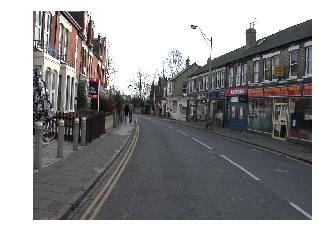

In [0]:
img = open_image(fnames[1])
img.show(figsize=(5, 5))


Image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

In [0]:
get_label_name_from_image = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

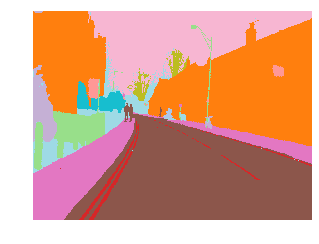

In [0]:
img = fnames[1]
mask = open_mask(get_label_name_from_image(fnames[1]))
mask.show(figsize=(5, 5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [0]:
mask.data

tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_images)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_label_name_from_image, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

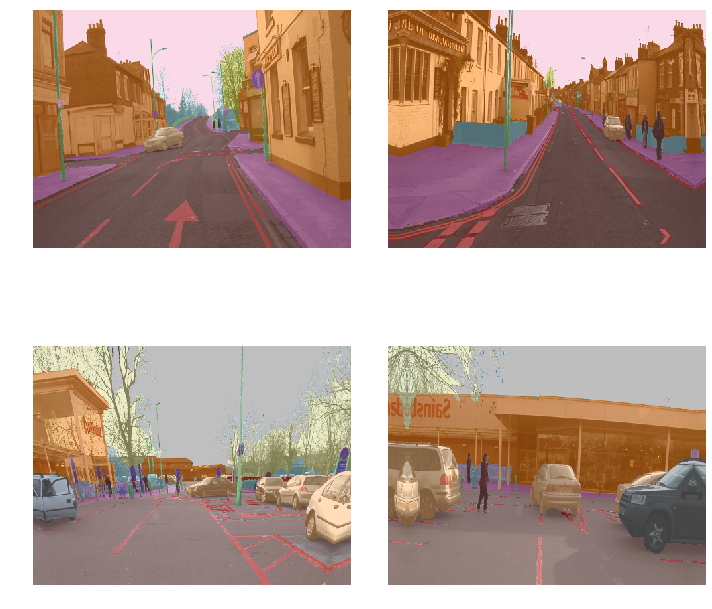

In [0]:
data.show_batch(rows=2, figsize=(10, 10))

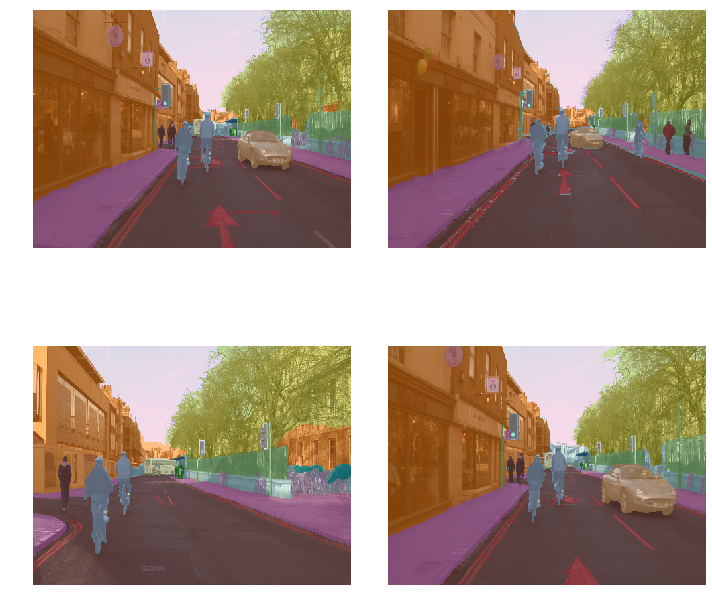

In [0]:
data.show_batch(2, figsize=(10, 10), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
model_34 = unet_learner(data, models.resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 111748474.60it/s]


In [0]:
lr_find(model_34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


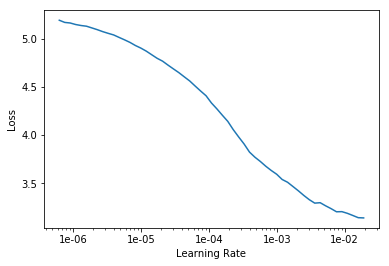

In [0]:
model_34.recorder.plot()

In [0]:
lr = 1e-03
model_34.fit_one_cycle(10, slice(lr))

In [0]:
model_34.save('91.7%_accuracy')

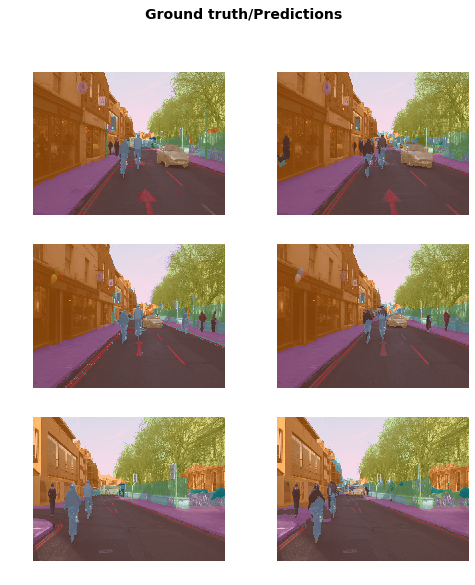

In [0]:
model_34.show_results(rows=3, figsize=(8,9))

In [0]:
model_34.unfreeze()

In [0]:
lr_find(model_34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


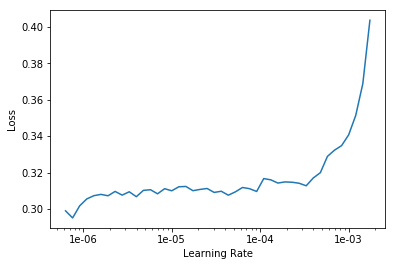

In [0]:
model_34.recorder.plot()

In [0]:
lrs = slice(lr/400, lr/4)
model_34.fit_one_cycle(12, lrs)

In [0]:
model_34.save('92.4%_accuracy')

## Exceeding the accuracy

In [0]:
size = src_size

free = gpu_mem_get_free_no_cache()
bs = 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 11430MB of GPU RAM free


In [0]:
wd=1e-3
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
model_34 = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
model_34.load('92.4%_accuracy')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d

In [0]:
lr_find(model_34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


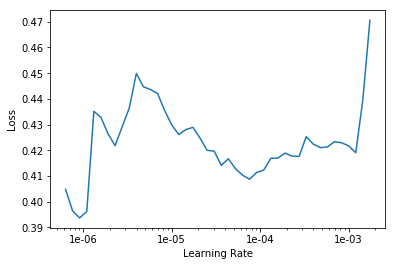

In [0]:
model_34.recorder.plot()

In [0]:
lr = 1e-3
model_34.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [0]:
model_34.save('92.5%_accuracy')

In [0]:
model_34.load('92.5%_accuracy')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d

In [0]:
model_34.unfreeze()

In [0]:
lrs = slice(1e-6, lr/10)
model_34.fit_one_cycle(10, lrs)

In [0]:
model_34.save('93.2%_accuracy')

In [0]:
model_34.load('93.2%_accuracy')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d

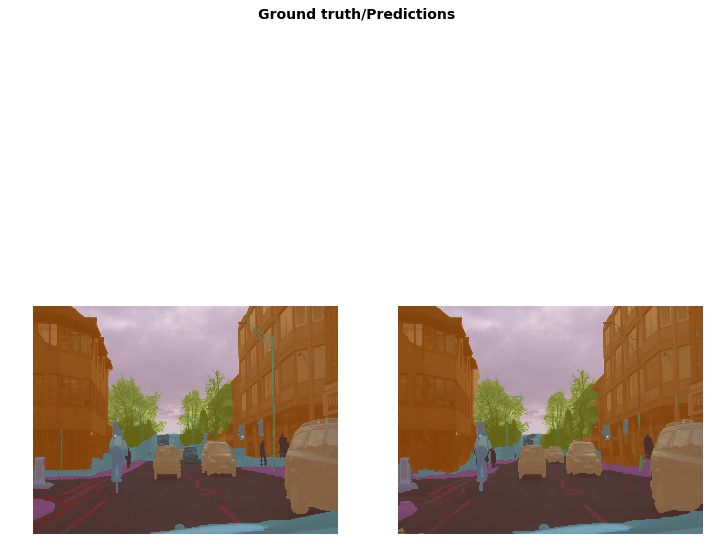

In [0]:
model_34.show_results(2, figsize=(12, 12))

In [0]:
model_34.export('Final_model_segmentation.pkl')

## Loading the exported model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.basic_train import *

model = load_learner('/content/drive/My Drive/','Final_model_segmentation.pkl')

## Making predictions on holdout dataset

In [0]:
img = open_image('imgs/car_example.jpg')
mask = open_mask('imgs/mask_example.png')
_,axs = plt.subplots(1,3, figsize=(8,4))
img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)

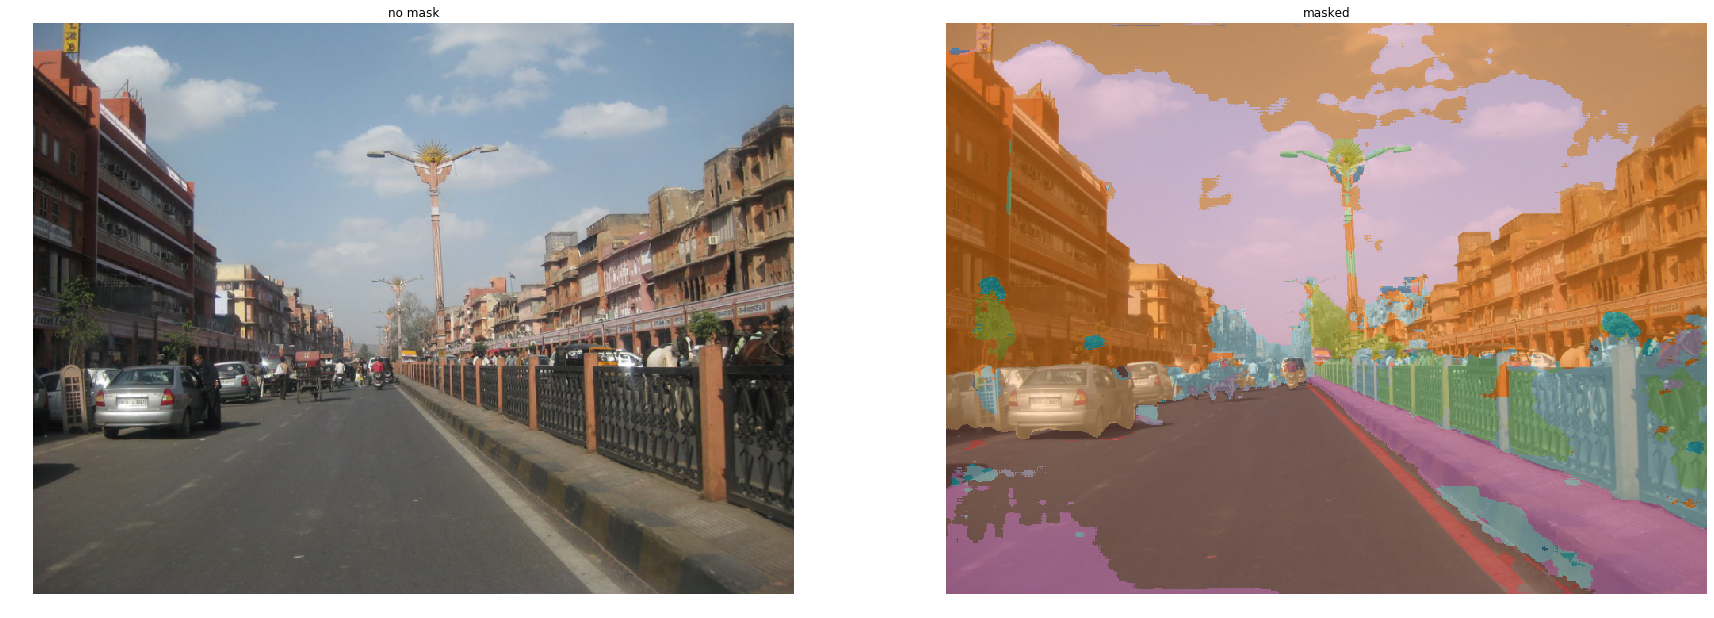

In [18]:
size = (1, 720, 960)

pic_1 = open_image('/content/pic_1.jpg')
pic_1_resized = pic_1.resize((size))
_,axs = plt.subplots(1,2, figsize=(30,30))
mask_1 = model.predict(pic_1_resized)[0]
pic_1_resized.show(ax=axs[0], title='no mask')
pic_1_resized.show(ax=axs[1], y=mask_1, title='masked')

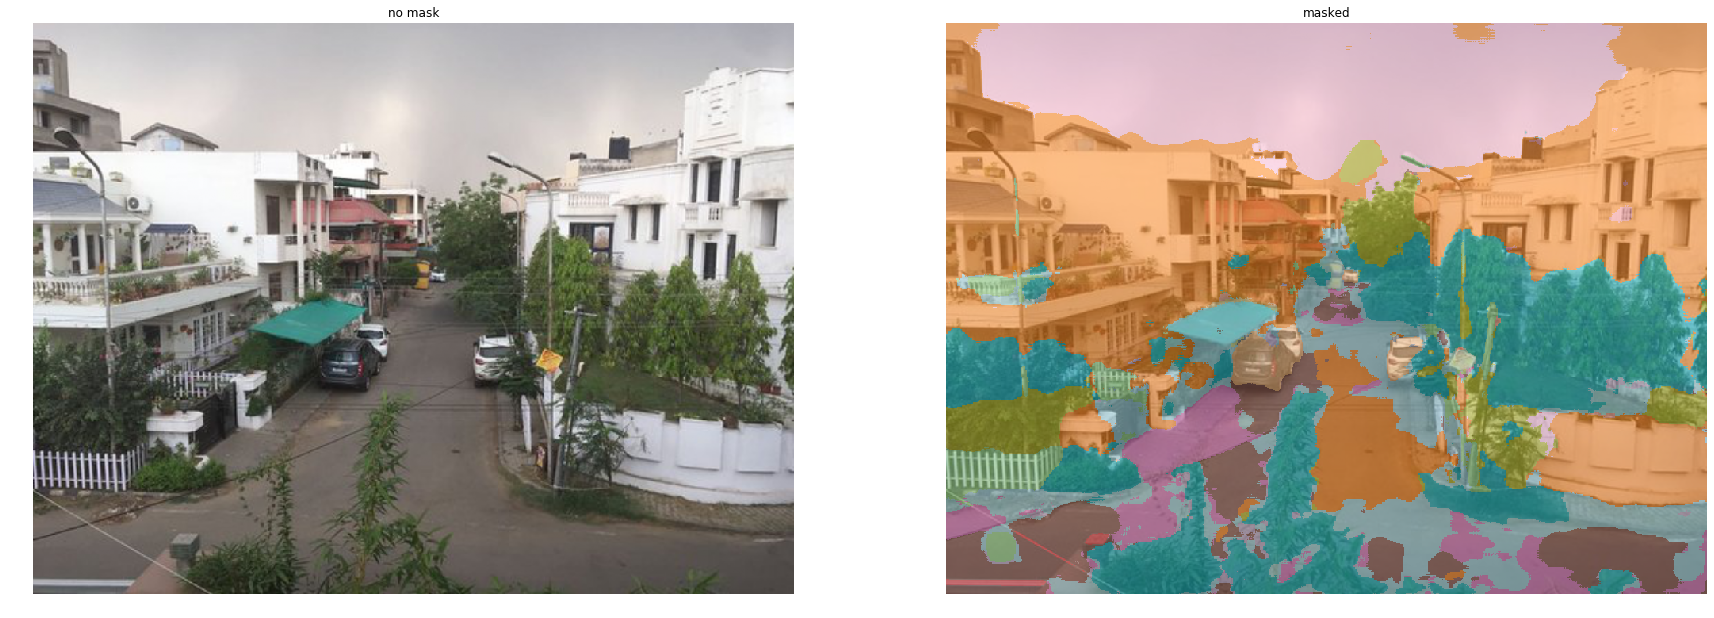

In [20]:
pic_2 = open_image('/content/pic_2.jpg')
pic_2_resized = pic_2.resize((size))
_,axs = plt.subplots(1,2, figsize=(30,30))
mask_2 = model.predict(pic_2_resized)[0]
pic_2_resized.show(ax=axs[0], title='no mask')
pic_2_resized.show(ax=axs[1], y=mask_2, title='masked')

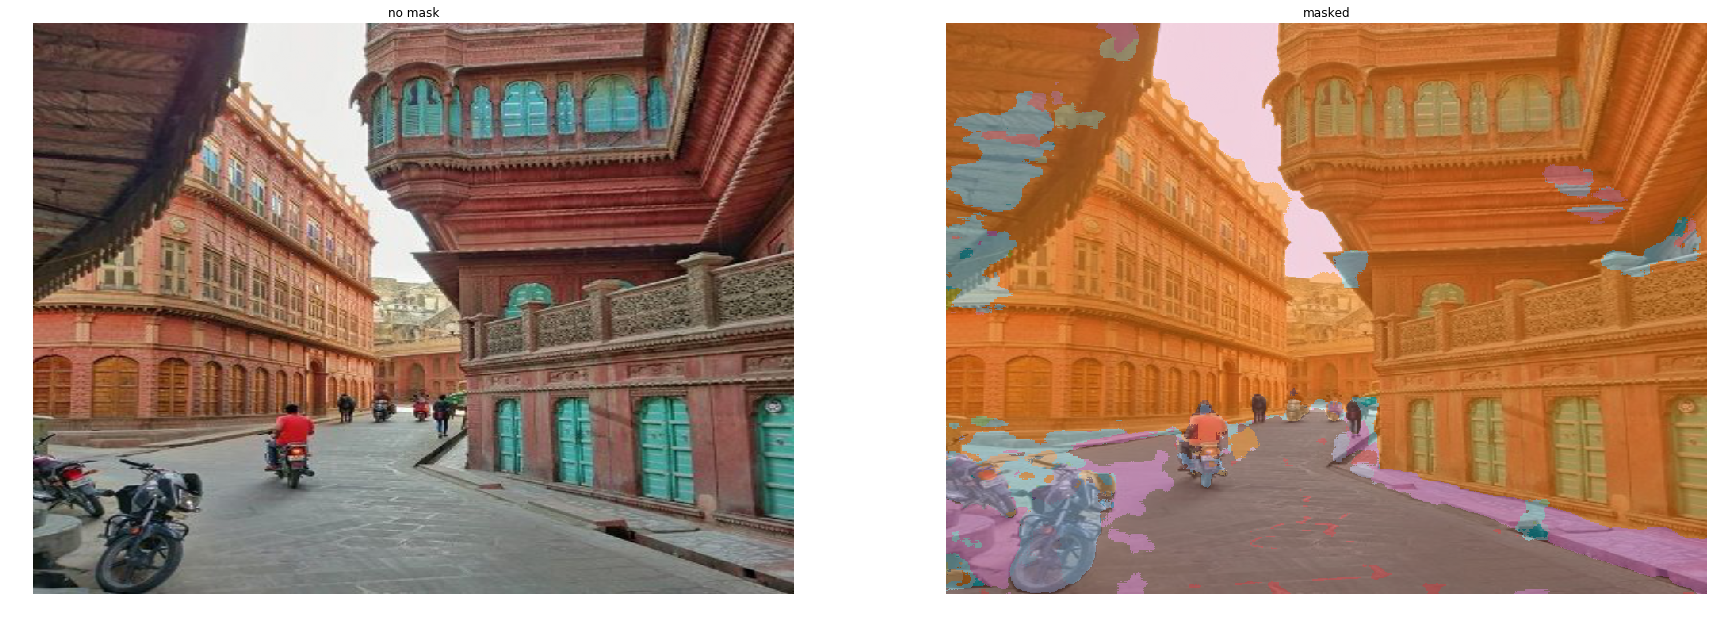

In [24]:
pic_3 = open_image('/content/pic_3.jpg')
pic_3_resized = pic_3.resize((size))
_,axs = plt.subplots(1,2, figsize=(30,30))
mask_3 = model.predict(pic_3_resized)[0]
pic_3_resized.show(ax=axs[0], title='no mask')
pic_3_resized.show(ax=axs[1], y=mask_3, title='masked')

##Questions:

1. How good was your model at predicting this "holdout" test set
2. Where is it having difficulty or particular success?
3. Describe 2 strategies that you could legitimately use, with the resources you have, to increase this quality given that you would not be privy to these images.



##Answers 1:

The model was working fine as long the there were street views, cars or motor vehicles. But the moment you try to predict a mask of an object **which is not in the code list**, it doesn't do really well. you can see for yourself that the model is masking the buildings and vehicles pretty much well but when it comes to predicting the mask of an unknown object it is not delivering that promising results. So "How good was my model at predicting this "holdout" test set?" **It's excellent if the model has seen the data already but it's good when it has been put as holdout dataset.**


##Answer 2:

I was having diffiuclty dealing with the **image size** and **batch size** both. If you try to train the `resnet34` model on full image size, kernel will take longer time to train the model on the images. For the batch size, if you try bigger batch size you will ran out the memory.

##Answer 3:
We can 2 methods with the limited resources to improve the quality **while not keeping these images in holdout dataset**:
1. Transfer Learning: We can train the model on half of the image size and train it again while limiting the batch size of databunch. This will take less time and going to yield over 93% accuracy, which is good.

2. Tweaking the learning rate: Since ***most*** of the gradient algorithms are based upon **Stochastic Gradient Descent** so the learning rate is subject to simulated annealing, an algorithm inspired from the process in metallurgy of annealing, where molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.